In [17]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [18]:
tf.__version__

'2.9.1'

In [128]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [129]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [130]:
dataset = tf.keras.utils.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [131]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [58]:
len(dataset)

68

In [132]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 2 1 0 0 1 0 1 0 1 1 0 1 1 2 1 1 1 1 0 0 0 0 0 0 0 1 0 0 2 0]


In [133]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


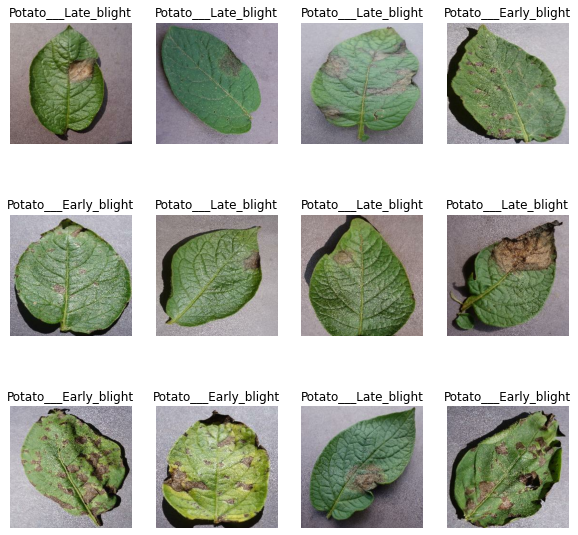

In [28]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [134]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [135]:
train_ds = dataset.take(54)
len(train_data)

NameError: name 'train_data' is not defined

In [40]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [41]:
# validation dataset
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [43]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [44]:
test_ds=test_ds.skip(6)
len(test_data)

8

In [136]:
#### Creating a function to partition th tensorflow dataset
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [137]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [138]:
len(train_ds)

54

In [139]:
len(val_ds)

6

In [140]:
len(test_ds)

8

In [141]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [142]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [143]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [144]:
###### Building CNN Model
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [145]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [146]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [148]:
history = model.fit(
    train_ds,
    epochs=40,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/40
54/54 [==============================] - 22s 410ms/step - loss: 0.3274 - accuracy: 0.8663 - val_loss: 0.2289 - val_accuracy: 0.9062
Epoch 2/40
54/54 [==============================] - 23s 424ms/step - loss: 0.2259 - accuracy: 0.9144 - val_loss: 0.2631 - val_accuracy: 0.8958
Epoch 3/40
54/54 [==============================] - 24s 437ms/step - loss: 0.2975 - accuracy: 0.8796 - val_loss: 0.2845 - val_accuracy: 0.8750
Epoch 4/40
54/54 [==============================] - 25s 472ms/step - loss: 0.2207 - accuracy: 0.9138 - val_loss: 0.2753 - val_accuracy: 0.8906
Epoch 5/40
54/54 [==============================] - 25s 472ms/step - loss: 0.1817 - accuracy: 0.9288 - val_loss: 0.1930 - val_accuracy: 0.9219
Epoch 6/40
54/54 [==============================] - 24s 448ms/step - loss: 0.1810 - accuracy: 0.9294 - val_loss: 0.1473 - val_accuracy: 0.9479
Epoch 7/40
54/54 [==============================] - 24s 441ms/step - loss: 0.1440 - accuracy: 0.9410 - val_loss: 0.2106 - val_accuracy: 0.9219

In [67]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 427ms/step - loss: 0.0159 - accuracy: 0.9961


In [150]:
scores

[0.04859395697712898, 0.99609375]

In [151]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [152]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [153]:
len(history.history['accuracy'])

40

In [154]:
history.history['accuracy']

[0.8663194179534912,
 0.9143518805503845,
 0.8796296119689941,
 0.9137731194496155,
 0.9288194179534912,
 0.9293981194496155,
 0.9409722089767456,
 0.9490740895271301,
 0.9270833134651184,
 0.9548611044883728,
 0.9473379850387573,
 0.9658564925193787,
 0.9450231194496155,
 0.9652777910232544,
 0.9646990895271301,
 0.9641203880310059,
 0.9646990895271301,
 0.9658564925193787,
 0.9785879850387573,
 0.9745370149612427,
 0.96875,
 0.9837962985038757,
 0.9450231194496155,
 0.9693287014961243,
 0.9837962985038757,
 0.9837962985038757,
 0.9785879850387573,
 0.9855324029922485,
 0.96875,
 0.953125,
 0.9693287014961243,
 0.9820601940155029,
 0.9809027910232544,
 0.9884259104728699,
 0.9918981194496155,
 0.9930555820465088,
 0.9878472089767456,
 0.9814814925193787,
 0.984375,
 0.9878472089767456]

In [155]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

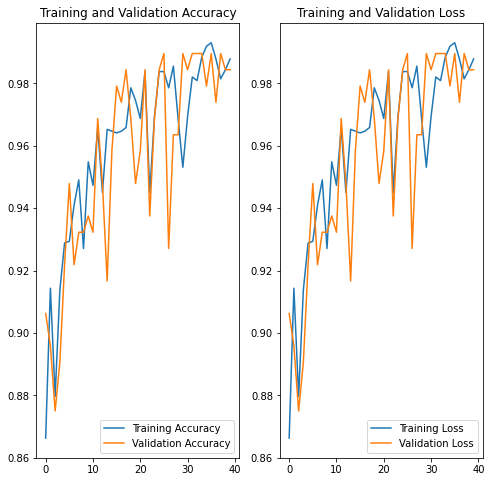

In [157]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(40),acc,label='Training Accuracy')
plt.plot(range(40),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(40),acc,label='Training Loss')
plt.plot(range(40),val_acc,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label:  Potato___Early_blight
1/1 [==============================] - 1s 528ms/step
[9.9760747e-01 2.3918238e-03 7.6321828e-07]
0
Predicted label:  Potato___Early_blight


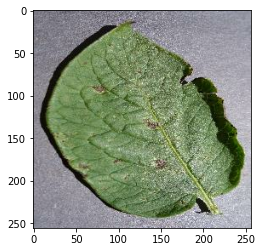

In [158]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = labels_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label: ",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    
    # to get index of maximum from above prediction
    print(np.argmax(batch_prediction[0]))
    
    # predicted label
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [94]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 42ms/step


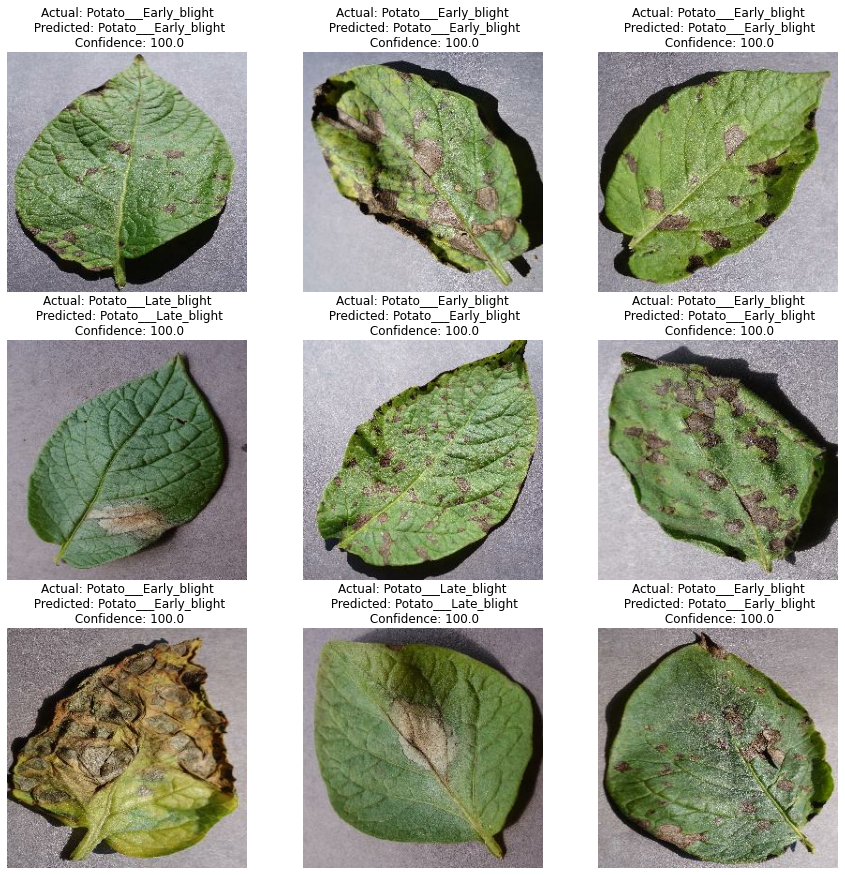

In [111]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence = predict(model,images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}")
        
        plt.axis("off")
    plt.show()

In [112]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [170]:
model.save('myModel.h5')

In [171]:
model.save('myModel.hdf5')

In [6]:
import os
print(os.getcwd())

E:\Data_Science_Projects\Deep Learning\Disease\training


In [4]:
from keras.models import load_model

In [5]:
import numpy as np
from PIL import Image
import tensorflow as tf

In [502]:
model = tf.keras.models.load_model("saved_models/1")

In [491]:
model = tf.keras.models.load_model("myModel.hdf5")

In [330]:
image = Image.open("E:/Data_Science_Projects/deep_learning/potato_disease/training/potato-late-blight.jpg") 

In [331]:
nimg = np.array(image)
img = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

In [332]:
img

array([[[137, 216, 183],
        [136, 215, 182],
        [137, 213, 181],
        ...,
        [101, 156, 139],
        [101, 156, 139],
        [101, 156, 139]],

       [[138, 217, 184],
        [138, 217, 184],
        [139, 215, 183],
        ...,
        [ 99, 154, 137],
        [100, 155, 138],
        [100, 155, 138]],

       [[142, 218, 186],
        [141, 217, 185],
        [142, 217, 185],
        ...,
        [ 99, 153, 136],
        [ 99, 153, 136],
        [ 99, 153, 136]],

       ...,

       [[ 67, 107,  82],
        [ 73, 113,  88],
        [ 76, 115,  90],
        ...,
        [  8,  24,  36],
        [  0,   9,  21],
        [  0,   0,  12]],

       [[ 68, 108,  83],
        [ 69, 109,  84],
        [ 71, 110,  85],
        ...,
        [  0,   1,   5],
        [  0,   0,   3],
        [  0,   0,   3]],

       [[ 84, 124,  99],
        [ 81, 121,  96],
        [ 83, 122,  97],
        ...,
        [  2,   3,   1],
        [  6,   7,   3],
        [  9,  10,   6]]

In [415]:
import cv2

In [364]:
image = Image.open("E:/Data_Science_Projects/deep_learning/potato_disease/training/new.jpg") 
image = image.save("img.jpg")

In [523]:
image1 = cv2.imread("E:/Data_Science_Projects/deep_learning/potato_disease/training/new1.jpg")

In [524]:
image1.shape

(280, 364, 3)

In [525]:
image1 = cv2.resize(image1,(256,256))

In [526]:
img_batch = np.expand_dims(image1,0)

In [527]:
predictions = model.predict(img_batch)

1/1 [==============================] - 0s 42ms/step


In [528]:
predictions

array([[3.2690048e-04, 1.9538246e-02, 9.8013490e-01]], dtype=float32)

In [529]:
CLASS_NAMES = ["Early Blight","Late Blight","Healthy"]

In [530]:
predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
confidence = np.max(predictions[0])

In [531]:
predicted_class

'Healthy'

In [532]:
confidence

0.9801349